### <center> Análise Preditiva: gênero
**Método:** Classificatório

**Objetivo:** Preve o gênero que será mais ouvido ao final do ano baseado no histórico do usuário

In [52]:
# Importações
import spotipy
import os 
import dotenv
import requests
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [20]:
# Lê o csv com o gênero das músicas
df = pd.read_csv('spotify_songs_giovanne.csv')

### Compreensão dos Dados

In [80]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6189 entries, 0 to 6188
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 6189 non-null   object 
 1   platform                           6189 non-null   object 
 2   ms_played                          6189 non-null   int64  
 3   conn_country                       6189 non-null   object 
 4   ip_addr                            6189 non-null   object 
 5   master_metadata_track_name         6189 non-null   object 
 6   master_metadata_album_artist_name  6189 non-null   object 
 7   master_metadata_album_album_name   6189 non-null   object 
 8   spotify_track_uri                  6189 non-null   object 
 9   episode_name                       0 non-null      float64
 10  episode_show_name                  0 non-null      float64
 11  spotify_episode_uri                0 non-null      float

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,genero
0,2025-07-01T11:18:37Z,windows,5658,BR,170.85.20.197,Stop Crying Your Heart Out,Oasis,Heathen Chemistry,spotify:track:5YciOakY5dB5dULkiLdCaf,NaN,...,NaN,NaN,remote,switched-to-video,True,False,False,1751368710,False,britpop
1,2025-07-01T11:23:39Z,windows,296006,BR,170.85.20.197,Stop Crying Your Heart Out,Oasis,Heathen Chemistry,spotify:track:5YciOakY5dB5dULkiLdCaf,NaN,...,NaN,NaN,switched-to-audio,trackdone,True,False,False,1751368723,False,britpop
2,2025-07-01T11:27:20Z,windows,220497,BR,170.85.20.197,tv off (feat. lefty gunplay),Kendrick Lamar,GNX,spotify:track:0aB0v4027ukVziUGwVGYpG,NaN,...,NaN,NaN,trackdone,trackdone,True,False,False,1751369019,False,hip hop
3,2025-07-01T11:31:17Z,windows,236646,BR,170.85.20.197,Cocoon,Catfish and the Bottlemen,The Balcony,spotify:track:1B241LRKmK6qDDTZfUajmm,NaN,...,NaN,NaN,trackdone,trackdone,True,False,False,1751369240,False,indie
4,2025-07-01T11:35:18Z,windows,240315,BR,170.85.20.197,Sweater Weather,The Neighbourhood,I Love You.,spotify:track:2QjOHCTQ1Jl3zawyYOpxh6,NaN,...,NaN,NaN,trackdone,trackdone,True,False,False,1751369478,False,indie


- Analisar esse df
- dropar as colunas que não preciso
- fazer uma contagem de quantas vezes cada gênero aparece
- somar o ms_played (duração em milissegundos de cada música) por gênero - talvez converter para segundos ou minutos
- calcular uma porcentagem de plays por gênero (total de todas as musicas/ musicas daquele genero)
- (ideia) apagar do df as músicas que foram puladas


### Preparação dos Dados

In [82]:
# COlunas necessárias: ts, ms_played, master_metadata_album_artist_name, shuffle, skipped, genero

# Copiando os dados para outro df
df_genre = df.copy()

# Excluindo colunas desnecessárias
df_genre = df_genre.drop(columns=['platform', 'conn_country', 'ip_addr', 'master_metadata_track_name', 'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name', 'episode_show_name', 'spotify_episode_uri', 'audiobook_uri', 'audiobook_title', 'audiobook_chapter_uri', 'audiobook_chapter_title', 'reason_start', 'reason_end', 'offline', 'offline_timestamp', 'incognito_mode'])

# df limpo
display(df_genre.head())

,ts,ms_played,master_metadata_album_artist_name,shuffle,skipped,genero
0,2025-07-01T11:18:37Z,5658,Oasis,True,False,britpop
1,2025-07-01T11:23:39Z,296006,Oasis,True,False,britpop
2,2025-07-01T11:27:20Z,220497,Kendrick Lamar,True,False,hip hop
3,2025-07-01T11:31:17Z,236646,Catfish and the Bottlemen,True,False,indie
4,2025-07-01T11:35:18Z,240315,The Neighbourhood,True,False,indie


In [83]:
# (ideia) apagar do df as músicas que foram puladas
df_genre.drop(
    df_genre[(df_genre['shuffle'] == True) & (df_genre['skipped'] == True)].index, 
    inplace=True)

display(df_genre.head())

,ts,ms_played,master_metadata_album_artist_name,shuffle,skipped,genero
0,2025-07-01T11:18:37Z,5658,Oasis,True,False,britpop
1,2025-07-01T11:23:39Z,296006,Oasis,True,False,britpop
2,2025-07-01T11:27:20Z,220497,Kendrick Lamar,True,False,hip hop
3,2025-07-01T11:31:17Z,236646,Catfish and the Bottlemen,True,False,indie
4,2025-07-01T11:35:18Z,240315,The Neighbourhood,True,False,indie


In [86]:
# Converter timestamp
df_genre['ts'] = pd.to_datetime(df['ts'])

# Criar colunas úteis
df_genre['ano'] = df_genre['ts'].dt.year
df_genre['mes'] = df_genre['ts'].dt.to_period('M')

# Converter ms_played → minutos
df_genre['min_played'] = df_genre['ms_played'] / 60000

display(df_genre)


C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_14944\2075590818.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_genre['mes'] = df_genre['ts'].dt.to_period('M')


,ts,ms_played,master_metadata_album_artist_name,shuffle,skipped,genero,ano,mes,min_played
0,2025-07-01 11:18:37+00:00,5658,Oasis,True,False,britpop,2025,2025-07,0.094300
1,2025-07-01 11:23:39+00:00,296006,Oasis,True,False,britpop,2025,2025-07,4.933433
2,2025-07-01 11:27:20+00:00,220497,Kendrick Lamar,True,False,hip hop,2025,2025-07,3.674950
3,2025-07-01 11:31:17+00:00,236646,Catfish and the Bottlemen,True,False,indie,2025,2025-07,3.944100
4,2025-07-01 11:35:18+00:00,240315,The Neighbourhood,True,False,indie,2025,2025-07,4.005250
...,...,...,...,...,...,...,...,...,...
6184,2026-01-29 19:13:50+00:00,105619,Laura Shigihara,True,False,Soundtrack,2026,2026-01,1.760317
6185,2026-01-29 19:16:46+00:00,177427,Two Door Cinema Club,True,False,indie,2026,2026-01,2.957117
6186,2026-01-29 19:21:20+00:00,276200,Arctic Monkeys,True,False,indie,2026,2026-01,4.603333
6187,2026-01-29 19:24:14+00:00,175373,Titãs,True,False,brazilian rock,2026,2026-01,2.922883


### Features

In [89]:
# Agregação mensal por gênero
df_month = (
    df_genre.groupby(['mes', 'genero'])
      .agg(
          plays=('genero', 'count'),
          total_min=('min_played', 'sum')
      )
      .reset_index()
)

display(df_month)

,mes,genero,plays,total_min
0,2025-07,Hip-Hop,14,41.852317
1,2025-07,Progressive rock,1,3.451133
2,2025-07,Soundtrack,4,7.816417
3,2025-07,Video game OST,1,3.809517
4,2025-07,acid jazz,2,7.646167
...,...,...,...,...
592,2026-01,sertanejo,3,10.092000
593,2026-01,soul,3,9.891633
594,2026-01,southern rock,1,7.833317
595,2026-01,synthpop,4,14.678100


In [102]:

# Pivotar (cada gênero vira coluna)
df_pivot = df_month.pivot(index='mes', columns='genero', values='total_min').fillna(0)

# Total geral por mês
df_pivot['total_geral'] = df_pivot.sum(axis=1)

# Porcentagem por gênero
for col in df_pivot.columns[:-1]:
    df_pivot[f'perc_{col}'] = df_pivot[col] / df_pivot['total_geral']

C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_14944\3789473067.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivot[f'perc_{col}'] = df_pivot[col] / df_pivot['total_geral']
C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_14944\3789473067.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivot[f'perc_{col}'] = df_pivot[col] / df_pivot['total_geral']
C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_14944\3789473067.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

In [103]:
display(df_pivot)

genero,80s,All,Drum and bass,Garage Rock,Hip-Hop,House,Korean,Lo-Fi,Portugal,Progressive rock,...,perc_thrash metal,perc_trap,perc_trap latino,perc_trip hop,perc_tropical house,perc_uk garage,perc_underground hip hop,perc_video game music,perc_witch house,perc_world
mes,,,,,,,,,,,,,,,,,,,,,
2025-07,0.0000,0.000000,0.000000,0.000000,41.852317,0.00000,0.000000,0.000000,0.0000,3.451133,...,0.006557,0.000000,0.000000,0.001858,0.000000,0.00000,0.000000,0.002374,0.000000,0.000000
2025-08,8.1751,0.000000,8.204917,0.000000,21.991250,66.36230,3.766567,0.000000,0.0000,17.095950,...,0.008679,0.000000,0.000000,0.000000,0.002878,0.00000,0.000727,0.000000,0.000708,0.001133
2025-09,8.1751,0.000000,0.000000,3.294133,16.022900,9.25675,0.000000,0.000000,0.0000,12.291400,...,0.000977,0.000476,0.000475,0.000000,0.000899,0.00000,0.000000,0.000000,0.000000,0.000000
2025-10,0.0000,0.000000,0.000000,0.000000,4.956733,4.76920,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.009143,0.00000,0.000000,0.000000,0.000000,0.000000
2025-11,0.0000,0.000000,0.000000,0.000000,3.572267,0.00000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2025-12,0.0000,0.061333,0.000000,0.000000,19.181050,0.00000,0.000000,5.002883,5.9999,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002520,0.00133,0.000000,0.000000,0.001389,0.000000
2026-01,0.0000,9.131250,0.000000,0.000000,8.328433,0.00000,0.000000,0.000000,0.0000,3.451150,...,0.000000,0.000000,0.000000,0.000000,0.002561,0.00000,0.000000,0.000000,0.000000,0.000000


In [107]:
# criar o target
# Pegue apenas colunas que NÃO começam com 'perc_' 
# e NÃO sejam 'total_geral'

colunas_genero = [
    col for col in df_pivot.columns 
    if col != 'total_geral' and not col.startswith('perc_')
]
y = df_pivot[colunas_genero].idxmax(axis=1)

# lag feature (evitar vazamento temporal)
X = df_pivot.shift(1).dropna()
y = y.loc[X.index]

### Treino e Teste

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False
)

### Modelo

In [109]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=200
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### Resultado do Modelo

In [110]:
previsao_final = model.predict(X.tail(1))
print("Gênero previsto:", previsao_final[0])

Gênero previsto: indie


### Avaliação

In [111]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

              precision    recall  f1-score   support

       indie       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Matriz de Confusão:
[[2]]


C:\Users\sofiasantana-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


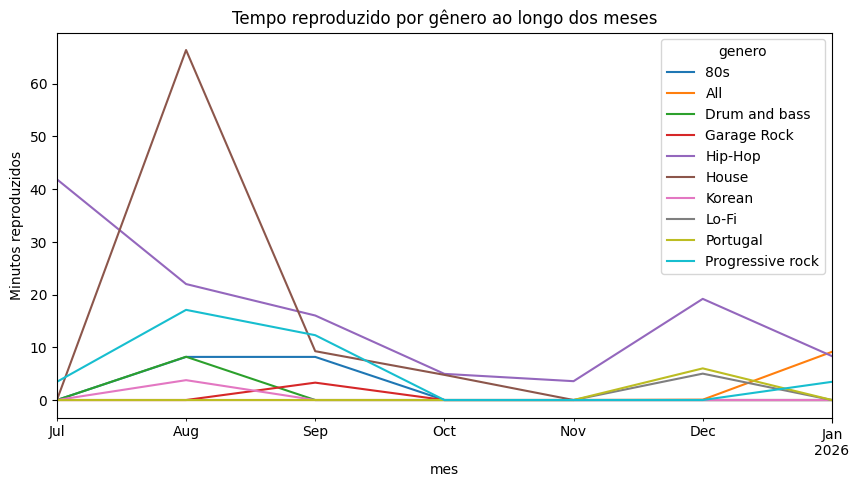

In [112]:
df_pivot[df_pivot.columns[:10]].plot(figsize=(10,5))
# df_pivot[df_pivot.columns].plot(figsize=(10,5))
plt.title("Tempo reproduzido por gênero ao longo dos meses")
plt.ylabel("Minutos reproduzidos")
plt.show()